# sunspot dataset for arima model

Sunspots are temporary phenomena on the Sun's photosphere that appear as spots darker than the surrounding areas. They are regions of reduced surface temperature caused by concentrations of magnetic field flux that inhibit convection. Sunspot activity cycles are about every eleven years, with some variation in length. Over the solar cycle, sunspot populations rise quickly and then fall more slowly.

The 11-year sunspot cycle is actually half of a longer, 22-year cycle of solar activity. Each time the sunspot count rises and falls, the magnetic field of the Sun associated with sunspots reverses polarity; the orientation of magnetic fields in the Sun's northern and southern hemispheres switch. Thus, in terms of magnetic fields, the solar cycle is only complete (with the fields back the way they were at the start of the cycle) after two 11-year sunspot cycles. This solar cycle is, on average, about 22 years long - twice the duration of the sunspot cycle.

importing all we need

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
import itertools
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Activation, Dropout
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller

using the github link we get our dataset

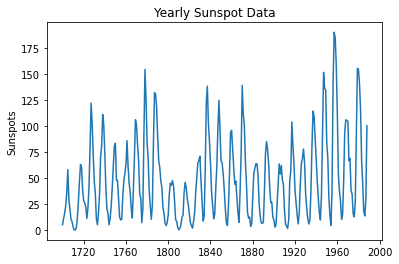

In [2]:
data_path = 'https://vincentarelbundock.github.io/Rdatasets/csv/datasets/sunspot.year.csv'
data = pd.read_csv(data_path,usecols = ['time','value'],index_col = 'time',parse_dates=['time'])
plt.figure()
plt.plot(data.index,data['value'])
plt.ylabel('Sunspots')
plt.title('Yearly Sunspot Data');

In [4]:
data

,value
time,
1700-01-01,5.0
1701-01-01,11.0
1702-01-01,16.0
1703-01-01,23.0
1704-01-01,36.0
...,...
1984-01-01,45.9
1985-01-01,17.9
1986-01-01,13.4


the function below shows us is timeseries staisionary or no

 before we can build a model, we must ensure that the time series is stationary. There are two primary way to determine whether a given time series is stationary.
Rolling Statistics: Plot the rolling mean and rolling standard deviation. The time series is stationary if they remain constant with time (with the naked eye look to see if the lines are straight and parallel to the x-axis).


Augmented Dickey-Fuller Test: The time series is considered stationary if the p-value is low (according to the null hypothesis) and the critical values at 1%, 5%, 10% confidence intervals are as close as possible to the ADF Statistics

In [5]:
def get_stationarity(timeseries):
    
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    result = adfuller(timeseries['value'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

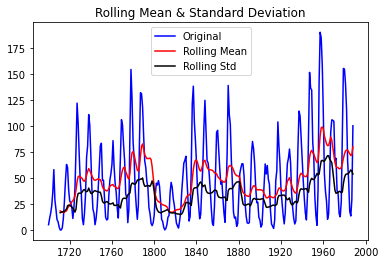

ADF Statistic: -2.3842262328920087
p-value: 0.14623801940950965
Critical Values:
	1%: -3.453922368485787
	5%: -2.871918329081633
	10%: -2.5723001147959184


In [9]:
get_stationarity(data)

<ipython-input-21-6e036e40af07>:1: RuntimeWarning: divide by zero encountered in log
  df_log = np.log(data)


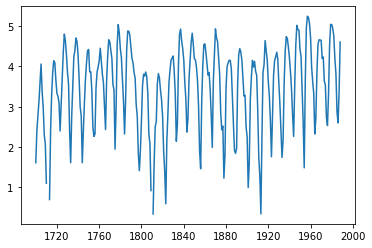

In [21]:
df_log = np.log(data)
plt.plot(df_log)

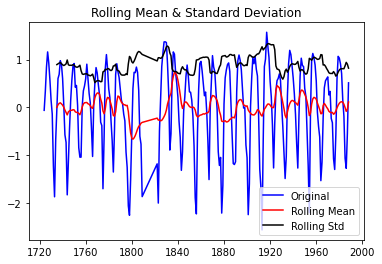

ADF Statistic: -4.618772792392304
p-value: 0.00011926034416589582
Critical Values:
	1%: -3.4575505077947746
	5%: -2.8735087323013526
	10%: -2.573148434859185


In [22]:
rolling_mean = df_log.rolling(window=12).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)
get_stationarity(df_log_minus_mean)

after looking at our plots and adfuller test we can now say if its staisionary or no

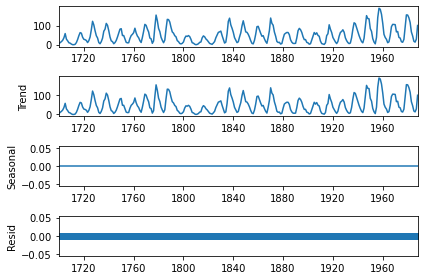

In [12]:
seasonal_decompose(data).plot();

# AutoRegressive Model (AR)
Autoregressive models operate under the premise that past values have an effect on current values. AR models are commonly used in analyzing nature, economics, and other time-varying processes. As long as the assumption holds, we can build a linear regression model that attempts to predict value of a dependent variable today, given the values it had on previous days.

# Moving Average Model (MA)
Assumes the value of the dependent variable on the current day depends on the previous days error terms.

# AutoRegressive Integrated Moving Average Model (ARIMA)
The ARIMA (aka Box-Jenkins) model adds differencing to an ARMA model. Differencing subtracts the current value from the previous and can be used to transform a time series into one that’s stationary. For example, first-order differencing addresses linear trends, and employs the transformation zi = yi — yi-1. Second-order differencing addresses quadratic trends and employs a first-order difference of a first-order difference, namely zi = (yi — yi-1) — (yi-1 — yi-2), and so on.

C:\Users\Admin\anaconda33\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


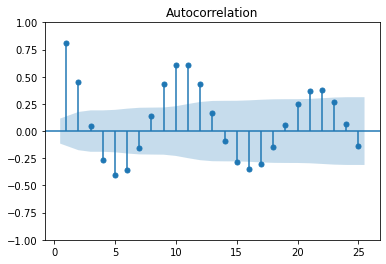

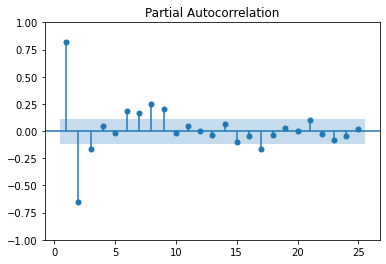

In [14]:
sm.tsa.graphics.plot_acf(data,zero=False)
sm.tsa.graphics.plot_pacf(data,zero = False);

In [16]:
auto_model = pm.auto_arima(data, start_p=0, start_q=0,
                           max_p=3, max_q=3, m=11,
                           start_P=0, seasonal=True,
                           d=0, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[11] intercept   : AIC=2720.600, Time=0.16 sec
 ARIMA(0,0,0)(0,1,0)[11] intercept   : AIC=2733.643, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[11] intercept   : AIC=2477.529, Time=0.19 sec
 ARIMA(0,0,1)(0,1,1)[11] intercept   : AIC=2523.292, Time=0.25 sec
 ARIMA(0,0,0)(0,1,0)[11]             : AIC=2733.338, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[11] intercept   : AIC=2510.090, Time=0.08 sec
 ARIMA(1,0,0)(2,1,0)[11] intercept   : AIC=2465.994, Time=0.63 sec
 ARIMA(1,0,0)(2,1,1)[11] intercept   : AIC=inf, Time=1.35 sec
 ARIMA(1,0,0)(1,1,1)[11] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(0,0,0)(2,1,0)[11] intercept   : AIC=2718.750, Time=0.63 sec
 ARIMA(2,0,0)(2,1,0)[11] intercept   : AIC=2393.815, Time=0.70 sec
 ARIMA(2,0,0)(1,1,0)[11] intercept   : AIC=2407.714, Time=0.33 sec
 ARIMA(2,0,0)(2,1,1)[11] intercept   : AIC=inf, Time=1.75 sec
 ARIMA(2,0,0)(1,1,1)[11] intercept   : AIC=inf, Time=0.87 sec
 ARIMA(3,0,0)(2,1,0)[11] intercept   : 

In [18]:
sar4 = sm.tsa.statespace.SARIMAX(data, 
                                order=(3,0,1), 
                                seasonal_order=(2,1,0,11), 
                                trend='c').fit()

C:\Users\Admin\anaconda33\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
C:\Users\Admin\anaconda33\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'


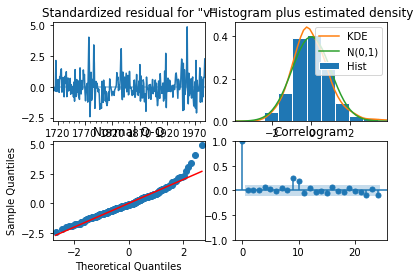

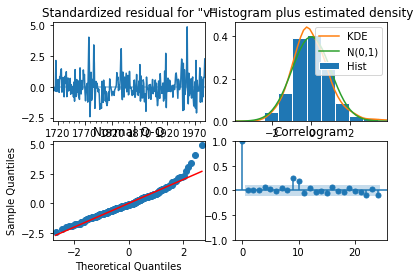

In [19]:
sar4.plot_diagnostics(lags=24)

## with grid search we found the best parameters for ar ma and s and i for the best model and we can see the plots above 

# deep learning  

for ddeep learning i used the five cities dataset and chengdu to analysis temp

In [26]:
df=pd.read_csv(r'C:\Users\Admin\Desktop\ML\IBM\time series\FiveCitiesPM\Chengdu.csv')
df = df[df.year >= 2015]

In [27]:
df['TEMP'] = df['TEMP'].interpolate()

In [28]:
def make_date(row):
    return datetime(year = row['year'], month = row['month'], day = row['day'], hour = row['hour'])
df['date'] = df.apply(make_date,axis=1)
df.set_index(df.date,inplace=True)

<AxesSubplot:xlabel='date'>

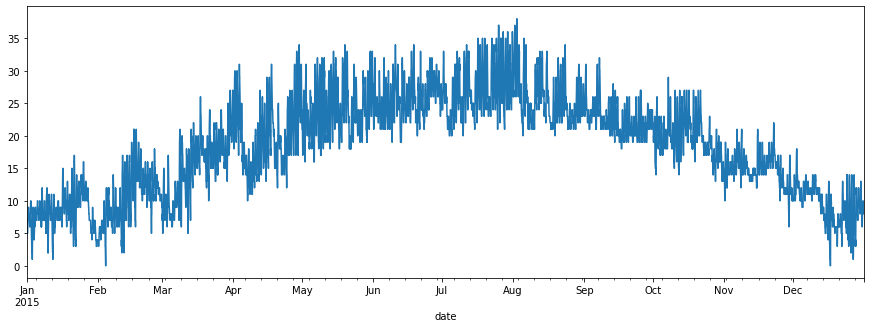

In [31]:
plt.figure(figsize = (15,5))
df['TEMP'].plot()

## clearly we can see the seasonality

In [29]:
def get_n_last_days(df, series_name, n_days):

    return df[series_name][-(24*n_days):] 

def plot_n_last_days(df, series_name, n_days):

    plt.figure(figsize = (10,5))   
    plt.plot(get_n_last_days(df, series_name, n_days), 'k-')
    plt.title('{0} Air Quality Time Series - {1} days'
              .format(series_name, n_days))
    plt.xlabel('Recorded Hour')
    plt.ylabel('Reading')
    plt.grid(alpha=0.3)

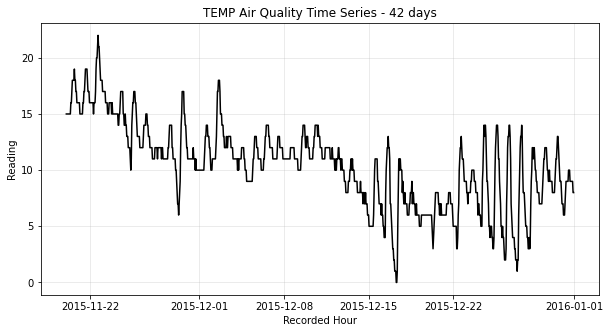

In [34]:
plot_n_last_days(df, 'TEMP', 42)

## making data keras friendly

In [36]:
def get_keras_format_series(series):
    series = np.array(series)
    return series.reshape(series.shape[0], series.shape[1], 1)

def get_train_test_data(df, series_name, series_days, input_hours, 
                        test_hours, sample_gap=3):

    forecast_series = get_n_last_days(df, series_name, series_days).values

    train = forecast_series[:-test_hours]
    test = forecast_series[-test_hours:] 

    train_X, train_y = [], []

    for i in range(0, train.shape[0]-input_hours, sample_gap): 
        train_X.append(train[i:i+input_hours]) 
        train_y.append(train[i+input_hours])

    train_X = get_keras_format_series(train_X)
    train_y = np.array(train_y)
    
   
    test_X_init = test[:input_hours] 
    test_y = test[input_hours:] 
    
    return train_X, test_X_init, train_y, test_y

In [37]:
series_days = 56
input_hours = 12
test_hours = 24

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(df, 'TEMP', series_days, 
                         input_hours, test_hours))

# RNN

In [38]:
def fit_rnn(train_X, train_y, cell_units, epochs):
    model = Sequential() 
    model.add(SimpleRNN(cell_units, input_shape=(train_X.shape[1],1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=1)
    
    return model  

In [39]:
model = fit_rnn(train_X, train_y, cell_units=10, epochs=10)

Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 168.2019
Epoch 2/10
7/7 [==============================] - 0s 1ms/step - loss: 163.7908
Epoch 3/10
7/7 [==============================] - 0s 1ms/step - loss: 159.4160
Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 155.1641
Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 151.1822
Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 147.6209
Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 144.5329
Epoch 8/10
7/7 [==============================] - 0s 2ms/step - loss: 141.8963
Epoch 9/10
7/7 [==============================] - 0s 2ms/step - loss: 139.5609
Epoch 10/10
7/7 [==============================] - 0s 2ms/step - loss: 137.5214


In [40]:
def predict(X_init, n_steps, model):
    X_init = X_init.copy().reshape(1,-1,1)
    preds = []

    for _ in range(n_steps):
        pred = model.predict(X_init)
        preds.append(pred)
        X_init[:,:-1,:] = X_init[:,1:,:] 
        X_init[:,-1,:] = pred
    preds = np.array(preds).reshape(-1,1)
    
    return preds
def predict_and_plot(X_init, y, model, title) :
    y_preds = predict(test_X_init, n_steps=len(y), model=model)
    start_range = range(1, test_X_init.shape[0]+1)
    predict_range = range(test_X_init.shape[0], test_hours)  
    
    plt.plot(start_range, test_X_init)
    plt.plot(predict_range, test_y, color='orange')
    plt.plot(predict_range, y_preds, color='teal', linestyle='--')
    
    plt.title(title)
    plt.legend(['Initial Series','Target Series','Predictions'])

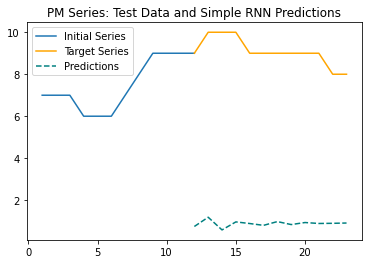

In [41]:
predict_and_plot(test_X_init, test_y, model,
                 'PM Series: Test Data and Simple RNN Predictions')

In [43]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 30)                960       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 991
Trainable params: 991
Non-trainable params: 0
_________________________________________________________________


Epoch 1/1200
7/7 [==============================] - 1s 2ms/step - loss: 144.9216
Epoch 2/1200
7/7 [==============================] - 0s 2ms/step - loss: 131.5516
Epoch 3/1200
7/7 [==============================] - 0s 1ms/step - loss: 118.8190
Epoch 4/1200
7/7 [==============================] - 0s 2ms/step - loss: 106.9917
Epoch 5/1200
7/7 [==============================] - 0s 2ms/step - loss: 96.6976
Epoch 6/1200
7/7 [==============================] - 0s 2ms/step - loss: 88.2021
Epoch 7/1200
7/7 [==============================] - 0s 2ms/step - loss: 81.1183
Epoch 8/1200
7/7 [==============================] - 0s 2ms/step - loss: 75.0102
Epoch 9/1200
7/7 [==============================] - 0s 1ms/step - loss: 69.5767
Epoch 10/1200
7/7 [==============================] - 0s 2ms/step - loss: 64.2011
Epoch 11/1200
7/7 [==============================] - 0s 2ms/step - loss: 58.4596
Epoch 12/1200
7/7 [==============================] - 0s 2ms/step - loss: 52.5960
Epoch 13/1200
7/7 [==============

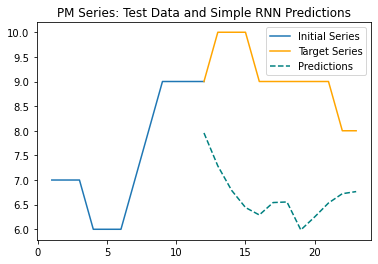

In [42]:
model = fit_rnn(train_X, train_y, cell_units=30, epochs=1200)
predict_and_plot(test_X_init, test_y, model,
                 'PM Series: Test Data and Simple RNN Predictions')

Epoch 1/2000
7/7 [==============================] - 0s 2ms/step - loss: 193.1652
Epoch 2/2000
7/7 [==============================] - 0s 2ms/step - loss: 180.0903
Epoch 3/2000
7/7 [==============================] - 0s 2ms/step - loss: 167.4129
Epoch 4/2000
7/7 [==============================] - 0s 2ms/step - loss: 155.1114
Epoch 5/2000
7/7 [==============================] - 0s 2ms/step - loss: 143.3311
Epoch 6/2000
7/7 [==============================] - 0s 2ms/step - loss: 132.4909
Epoch 7/2000
7/7 [==============================] - 0s 2ms/step - loss: 122.4843
Epoch 8/2000
7/7 [==============================] - 0s 2ms/step - loss: 113.2864
Epoch 9/2000
7/7 [==============================] - 0s 2ms/step - loss: 104.4902
Epoch 10/2000
7/7 [==============================] - 0s 2ms/step - loss: 96.4118
Epoch 11/2000
7/7 [==============================] - 0s 1ms/step - loss: 88.4781
Epoch 12/2000
7/7 [==============================] - 0s 2ms/step - loss: 80.6868
Epoch 13/2000
7/7 [=========

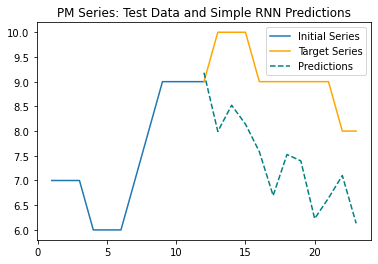

In [44]:
model = fit_rnn(train_X, train_y, cell_units=30, epochs=2000)
predict_and_plot(test_X_init, test_y, model,
                 'PM Series: Test Data and Simple RNN Predictions')

Epoch 1/400
6/6 [==============================] - 1s 4ms/step - loss: 120.8699
Epoch 2/400
6/6 [==============================] - 0s 4ms/step - loss: 88.2820
Epoch 3/400
6/6 [==============================] - 0s 4ms/step - loss: 65.1933
Epoch 4/400
6/6 [==============================] - 0s 4ms/step - loss: 47.9279
Epoch 5/400
6/6 [==============================] - 0s 4ms/step - loss: 35.0174
Epoch 6/400
6/6 [==============================] - 0s 4ms/step - loss: 26.8150
Epoch 7/400
6/6 [==============================] - 0s 4ms/step - loss: 20.9525
Epoch 8/400
6/6 [==============================] - 0s 4ms/step - loss: 16.3253
Epoch 9/400
6/6 [==============================] - 0s 4ms/step - loss: 13.2028
Epoch 10/400
6/6 [==============================] - 0s 4ms/step - loss: 10.8093
Epoch 11/400
6/6 [==============================] - 0s 4ms/step - loss: 9.0744
Epoch 12/400
6/6 [==============================] - 0s 4ms/step - loss: 7.7974
Epoch 13/400
6/6 [==============================] 

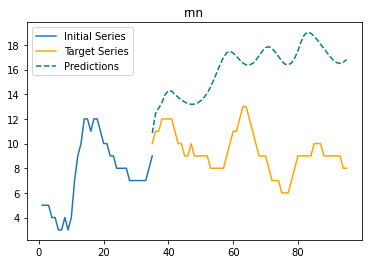

In [45]:
series_days = 50 
input_hours = 35
test_hours = 96

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(df, 'TEMP', series_days, 
                         input_hours, test_hours))

model = fit_rnn(train_X, train_y, cell_units=90, epochs=400) 

predict_and_plot(test_X_init, test_y, model,'rnn')

Epoch 1/600
6/6 [==============================] - 0s 4ms/step - loss: 103.5005
Epoch 2/600
6/6 [==============================] - 0s 4ms/step - loss: 69.5673
Epoch 3/600
6/6 [==============================] - 0s 4ms/step - loss: 48.0427
Epoch 4/600
6/6 [==============================] - 0s 4ms/step - loss: 34.5332
Epoch 5/600
6/6 [==============================] - 0s 4ms/step - loss: 25.9232
Epoch 6/600
6/6 [==============================] - 0s 4ms/step - loss: 20.0034
Epoch 7/600
6/6 [==============================] - 0s 4ms/step - loss: 15.6467
Epoch 8/600
6/6 [==============================] - 0s 4ms/step - loss: 12.4026
Epoch 9/600
6/6 [==============================] - 0s 4ms/step - loss: 9.9963
Epoch 10/600
6/6 [==============================] - 0s 4ms/step - loss: 8.3258
Epoch 11/600
6/6 [==============================] - 0s 4ms/step - loss: 7.1069
Epoch 12/600
6/6 [==============================] - 0s 4ms/step - loss: 6.1611
Epoch 13/600
6/6 [==============================] - 

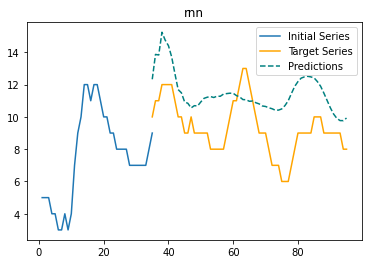

In [46]:
model = fit_rnn(train_X, train_y, cell_units=90, epochs=600) 

predict_and_plot(test_X_init, test_y, model,'rnn')

we made a solid RNN model that can predict our pattern but i wont go any further in case of not  overfitting the data

In [47]:
def fit_LSTM(train_X, train_y, cell_units, epochs):
    model = Sequential() 
    model.add(LSTM(cell_units, input_shape=(train_X.shape[1],1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=1)
    
    return model

Epoch 1/800
7/7 [==============================] - 1s 5ms/step - loss: 142.0466
Epoch 2/800
7/7 [==============================] - 0s 4ms/step - loss: 114.5587
Epoch 3/800
7/7 [==============================] - 0s 4ms/step - loss: 93.4908
Epoch 4/800
7/7 [==============================] - 0s 4ms/step - loss: 75.3629
Epoch 5/800
7/7 [==============================] - 0s 4ms/step - loss: 60.9366
Epoch 6/800
7/7 [==============================] - 0s 5ms/step - loss: 49.5218
Epoch 7/800
7/7 [==============================] - 0s 4ms/step - loss: 39.8753
Epoch 8/800
7/7 [==============================] - 0s 4ms/step - loss: 31.2450
Epoch 9/800
7/7 [==============================] - 0s 4ms/step - loss: 24.7329
Epoch 10/800
7/7 [==============================] - 0s 4ms/step - loss: 20.0730
Epoch 11/800
7/7 [==============================] - 0s 4ms/step - loss: 16.5952
Epoch 12/800
7/7 [==============================] - 0s 4ms/step - loss: 13.8419
Epoch 13/800
7/7 [=============================

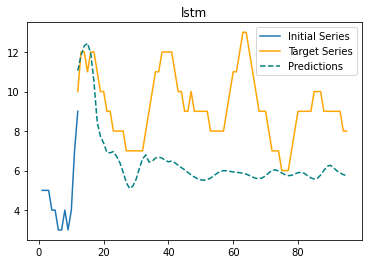

In [49]:
series_days = 60 
input_hours = 12
test_hours = 96

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(df, 'TEMP', series_days, 
                         input_hours, test_hours))

model = fit_LSTM(train_X, train_y, cell_units=70, epochs=800) 

predict_and_plot(test_X_init, test_y, model,'lstm')

Epoch 1/1200
7/7 [==============================] - 1s 5ms/step - loss: 164.6818
Epoch 2/1200
7/7 [==============================] - 0s 4ms/step - loss: 137.8953
Epoch 3/1200
7/7 [==============================] - 0s 5ms/step - loss: 113.0720
Epoch 4/1200
7/7 [==============================] - 0s 5ms/step - loss: 89.9945
Epoch 5/1200
7/7 [==============================] - 0s 5ms/step - loss: 71.4298
Epoch 6/1200
7/7 [==============================] - 0s 5ms/step - loss: 55.4566
Epoch 7/1200
7/7 [==============================] - 0s 5ms/step - loss: 41.8190
Epoch 8/1200
7/7 [==============================] - 0s 5ms/step - loss: 31.8991
Epoch 9/1200
7/7 [==============================] - 0s 5ms/step - loss: 25.3689
Epoch 10/1200
7/7 [==============================] - 0s 5ms/step - loss: 21.6482
Epoch 11/1200
7/7 [==============================] - 0s 5ms/step - loss: 18.9924
Epoch 12/1200
7/7 [==============================] - 0s 5ms/step - loss: 16.9035
Epoch 13/1200
7/7 [===============

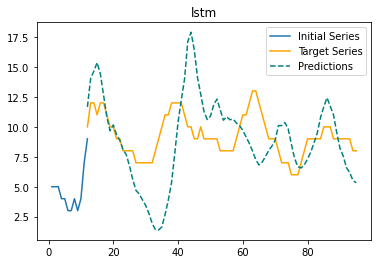

In [48]:
series_days = 60 
input_hours = 12
test_hours = 96

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(df, 'TEMP', series_days, 
                         input_hours, test_hours))

model = fit_LSTM(train_X, train_y, cell_units=70, epochs=1200) 

predict_and_plot(test_X_init, test_y, model,'lstm')

Epoch 1/1000
5/5 [==============================] - 1s 5ms/step - loss: 118.6785
Epoch 2/1000
5/5 [==============================] - 0s 4ms/step - loss: 98.9899
Epoch 3/1000
5/5 [==============================] - 0s 4ms/step - loss: 79.7435
Epoch 4/1000
5/5 [==============================] - 0s 4ms/step - loss: 62.4039
Epoch 5/1000
5/5 [==============================] - 0s 5ms/step - loss: 48.8201
Epoch 6/1000
5/5 [==============================] - 0s 4ms/step - loss: 38.6569
Epoch 7/1000
5/5 [==============================] - 0s 4ms/step - loss: 30.5362
Epoch 8/1000
5/5 [==============================] - 0s 4ms/step - loss: 24.4796
Epoch 9/1000
5/5 [==============================] - 0s 4ms/step - loss: 19.8948
Epoch 10/1000
5/5 [==============================] - 0s 5ms/step - loss: 16.8108
Epoch 11/1000
5/5 [==============================] - 0s 4ms/step - loss: 14.7630
Epoch 12/1000
5/5 [==============================] - 0s 4ms/step - loss: 13.4807
Epoch 13/1000
5/5 [=================

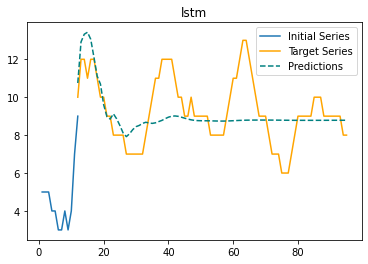

In [50]:
series_days = 40 
input_hours = 12
test_hours = 96

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(df, 'TEMP', series_days, 
                         input_hours, test_hours))

model = fit_LSTM(train_X, train_y, cell_units=70, epochs=1000) 

predict_and_plot(test_X_init, test_y, model,'lstm')

# recommeding our model
here we can use the sarima we found with grid search or out lstm model for deep learning 

### for next step  we can improve our rnn or lstm for the second part of the project for the first part we can try to analysis the data better and decompose our data better